In [2]:
import pandas as pd
import calendar
from datetime import datetime, timedelta

# 获取用户输入的日期（期货数据）
futures_date_str = input("请输入期货数据日期（YYYY-MM-DD）：")
futures_date = datetime.strptime(futures_date_str, "%Y-%m-%d")

# 获取用户输入的日期（股票数据）,需和所输入的期货数据日期保持一致
# stock_date_str = input("请输入股票数据日期（YYYY,M,D）：")
# stock_date = datetime.strptime(stock_date_str, "%Y,%m,%d")
stock_date_str = input("请输入股票数据日期（YYYY-MM-DD）：")
stock_date = datetime.strptime(stock_date_str, "%Y-%m-%d")

# 分别提取年、月、日
futures_start_year = int(futures_date.year)-1 #开始年份
futures_end_year=int(futures_date.year) #结束年份
futures_month = int(futures_date.month) #月份
futures_day = int(futures_date.day) #所输入的日期（后续应该用不到）
last_day = calendar.monthrange(futures_date.year, futures_date.month)[1] #计算所输入月份的最后一天

stock_start_year = int(stock_date.year)-1 #开始年份
stock_end_year = int(stock_date.year) #结束年份
stock_month = int(stock_date.month) #月份
stock_next_month = int(stock_date.month)+1 #所输入月份的下个月
stock_day = int(stock_date.day) #所输入的日期（后续应该用不到）
stock_last_day = calendar.monthrange(stock_date.year, stock_date.month)[1]

# 分别提取年、月、日(serve for model)
start_year = futures_start_year #开始年份
end_year = futures_end_year #结束年份
month = futures_month #月份
day = futures_day #所输入的日期
#last_day = calendar.monthrange(date.year, date.month)[1] 计算所输入月份的最后一天(may be deleted)
_,num_days = calendar.monthrange(end_year, month) #计算所输入月份有多少天

In [2]:
#下载期货数据

import datetime
import json
import requests
import traceback
import pandas as pd


def get_HisMainContract(variety=None, start=None, end=None):
    start_ = str(datetime.datetime.strptime(start, '%Y-%m-%d'))[:19]
    start_ = start_.replace('-', '').replace(':', '').replace(' ', '')
    end_ = str(datetime.datetime.strptime(end, '%Y-%m-%d'))[:19]
    end_ = end_.replace('-', '').replace(':', '').replace(' ', '')
    body = {'varietyCode': variety, 'begin': int(start_), 'end': int(end_)}
    try:
        url = "https://apigateway.inquantstudio.com/api/BasicData/GetHisMain"
        headers = {
            "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/75.0.3770.90 Safari/537.36",
            "Content-Type": "application/json"}
        response = requests.post(url, data=json.dumps(body), headers=headers)
        response.close()
    except Exception:
        print(traceback.format_exc())
    else:
        try:
            response_json = json.loads(response.content.decode())
            if response_json.get('error_no') == 0:
                return pd.DataFrame(response_json.get('data'))
            else:
                return response_json.get('error_info')
        except:
            print(traceback.format_exc())


def exchange2num(exchange):
    if exchange is None:
        return 4
    elif exchange == 'CFFEX':  # 中金所
        return 3
    elif exchange == 'SHFE':  # 上期所
        return 4
    elif exchange == 'DCE':  # 大商所
        return 5
    elif exchange == 'CZCE':  # 郑商所
        return 6
    elif exchange == 'INE':  # 上海国际能源交易中心
        return 15


def freq2dataType(freq=None):
    if freq is None:
        return 60
    elif freq == '10s':
        return 10
    elif freq == '1m':
        return 60
    elif freq == '5m':
        return 5 * 60
    elif freq == '15m':
        return 15 * 60
    elif freq == '30m':
        return 30 * 60
    elif freq == '60m':
        return 60 * 60
    elif freq == '1d':
        return 60 * 60 * 24
    elif freq == '1w':
        return 60 * 60 * 24 * 7
    else:
        return 60 * 60 * 24


def get_hisBar(symbol=None, exchange=None, freq=None, start=None, end=None, count=None):
    exchange_ = exchange2num(exchange)
    dataType = freq2dataType(freq=freq)
    url = ''
    body = {"symbol": symbol, "exchange": exchange_, "dataType": dataType, "dataSource": 1}
    if start and end and not count:
        if start == end and dataType == 86400:
            end_ = str(datetime.datetime.strptime(end, '%Y-%m-%d') + datetime.timedelta(days=1))[:19]
        else:
            end_ = end
        begin = start.replace('-', '').replace(' ', '').replace(':', '')
        end__ = end_.replace('-', '').replace(' ', '').replace(':', '')
        body['begin'] = begin
        body['end'] = end__
        url = "https://apigateway.inquantstudio.com/api/MarketData/GetHisBar"
    if not start and not end and count:
        body['count'] = count
        url = "https://apigateway.inquantstudio.com/api/MarketData/GetLastBar"
    if not start and end and count:
        end_ = end.replace('-', '').replace(' ', '').replace(':', '')
        if len(end_) == 8:
            end_ += '000000'
        if dataType == 86400 and count == 1:
            count_ = 1
            end_ = end_.replace('-', '').replace(' ', '').replace(':', '')
        else:
            count_ = count
        body['end'] = end_
        body['count'] = count_
        url = "https://apigateway.inquantstudio.com/api/MarketData/GetPreviousBar"
    try:
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows; U; Windows NT 6.1; en-US; rv:1.9.1.6) Gecko/20091201 Firefox/3.5.6",
            "Content-Type": "application/json"}
        response = requests.post(url, data=json.dumps(body), headers=headers)
        response.close()
    except Exception:
        print(traceback.format_exc())
        return None
    else:
        response = response.content.decode()
        response_json = json.loads(response)
        data = response_json.get('data')
        df_data = pd.DataFrame(data)
        if df_data.empty:
            return df_data
        df_data.columns = ['symbol', 'exchange', 'bar_type', 'time', 'pre_close', 'open', 'high', 'low', 'close',
                           'volume',
                           'turnover', 'open_interest', 'settlement']
        if start and end and not count:
            if start == end and dataType == 86400:
                begin = start.replace('-', '').replace(' ', '').replace(':', '')
                end = end.replace('-', '').replace(' ', '').replace(':', '')
                if len(begin) == 8:
                    begin += '000000'
                if len(end) == 8:
                    end += '000000'
                df_data = df_data[(df_data["time"] >= int(begin)) & (df_data["time"] <= int(end))]
        if not start and end and count:
            if dataType == 86400 and count == 1:
                df_data = df_data[-1:]
        df_data_ = df_data.sort_values(by='time').reset_index(drop=True)
        return df_data_


if __name__ == '__main__':
    # 返回历史主力合约
    futures_start_date = f"{futures_start_year}-{futures_month:02d}-01"
    futures_end_date = f"{futures_end_year}-{futures_month:02d}-{last_day:02d}"
    data = get_HisMainContract(variety='IF', start=futures_start_date, end=futures_end_date)
    #data = get_HisMainContract(variety='IF', start='futures_start_year-futures_month-01', end='futures_end_year-futures_month-31')
    print(data)
    # 期货K线数据
    data = get_hisBar(symbol='IFM', exchange='CFFEX', freq='1d', start=futures_start_date, end=futures_end_date)
    print(data)
futures = data[['time','close']] 
#futures = data['close'] 
print (futures)
futures.to_csv('futures.csv')

     tradeDate  symbol varietyCode
0     20220801  IF2209          IF
1     20220802  IF2209          IF
2     20220803  IF2209          IF
3     20220804  IF2209          IF
4     20220805  IF2209          IF
..         ...     ...         ...
259   20230823  IF2309          IF
260   20230824  IF2309          IF
261   20230825  IF2309          IF
262   20230828  IF2309          IF
263   20230829  IF2309          IF

[264 rows x 3 columns]
    symbol exchange  bar_type            time  pre_close    open    high  \
0      IFM    CFFEX     86400  20220801000000     4142.6  4135.0  4176.0   
1      IFM    CFFEX     86400  20220802000000     4162.6  4125.0  4127.0   
2      IFM    CFFEX     86400  20220803000000     4099.2  4117.4  4143.6   
3      IFM    CFFEX     86400  20220804000000     4050.2  4075.0  4093.0   
4      IFM    CFFEX     86400  20220805000000     4082.2  4092.8  4155.8   
..     ...      ...       ...             ...        ...     ...     ...   
259    IFM    CFFEX     

In [3]:
#下载股票数据

import numpy as np
import pandas as pd
import json
import requests
import urllib3
import tushare as ts
from datetime import datetime
from os.path import join

# this function is to get the corresponding code within the database for stocks
def getInnercode():
    urlstr = "https://stq.niuguwang.com/ft/innercode"
    header = {
        "User-Agent": "Mozilla/5.0 (Windows; U; Windows NT 6.1; en-US; rv:1.9.1.6) Gecko/20091201 Firefox/3.5.6",
        "Content-Type": "application/json"}
    Innercode = requests.get(urlstr, headers=header)
    Innercode_dict = json.loads(Innercode.content.decode("utf-8"))
    result = pd.DataFrame.from_dict(Innercode_dict["data"])
    return result

# this function is to download the data from database
def getAShrData(innercode, ktype, enddate, count, adj=True):
    """
    innercode : int
    ktype : int 1:5min; 2:15min; 3:30min; 4:60min; 5:1d; 6:1w; 9:1m, 11:1min
    enddate : str (not included)
    count : int
    adj : True/False
    """
    urlstr = "https://shqa.niuguwang.com/aquote/quote/kline.ashx?code={}&type={}&start={}&count={}&ex={}".format(
        innercode, ktype, enddate, count, int(adj))
    header = {
        "User-Agent": "Mozilla/5.0 (Windows; U; Windows NT 6.1; en-US; rv:1.9.1.6) Gecko/20091201 Firefox/3.5.6",
        "Content-Type": "application/json"}
    AShrData = requests.get(urlstr, headers=header)
    AShrData_dict = json.loads(AShrData.content.decode("utf-8"))
    result = pd.DataFrame.from_dict(AShrData_dict["timedata"])
    return result

# this function is to download the adjustment factors from the database
def getAdjFactor(ticker, startdate, enddate):
    startdate = startdate.strftime('%Y%m%d')
    enddate = enddate.strftime('%Y%m%d')
    tstoken = '5e8c8dc53d0b3a660989d14fc4b998cd865a27c9fe2e805246bfd9b3'
    pro = ts.pro_api(tstoken)
    adjfactor_df = pro.adj_factor(ts_code=ticker, start_date=startdate, end_date=enddate)
    adjfactor_df = adjfactor_df.set_index(["trade_date"])
    adjfactor_df = pd.DataFrame(adjfactor_df["adj_factor"])
    adjfactor_df.fillna(method="bfill", inplace=True)
    adjfactor_df.fillna(1, inplace=True)
    adjfactor_df.index = pd.to_datetime(adjfactor_df.index)
    adjfactor_df = adjfactor_df.sort_index()
    adjfactor_df = adjfactor_df.round(decimals=3)
    return adjfactor_df

# this function is to get the component of indexes
def getIndexComponents(idxcode, startdate, enddate):
    urlstr = "https://stq.niuguwang.com/NorthJg/GetNorthJg/hsweighthk"
    parms = {
        'sdate': startdate,
        'edate': enddate,
        'index_code': idxcode
    }
    headers = {
        'User-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.36',
        'Spam': 'Eggs',
        'Connection': 'close'
    }
    urllib3.disable_warnings()
    IndexComponents = requests.get(urlstr, data=parms, headers=headers, verify=False, timeout=600)
    IndexComponents_dict = json.loads(IndexComponents.content.decode("utf-8"))
    result = pd.DataFrame.from_dict(IndexComponents_dict)
    return result

if __name__ == '__main__':

    #################################################################
    # this part is to download the component of indexes from the database
    IndexComponents = getIndexComponents("000300.SH", "2020-09-01", "2022-09-30")
    # 000300.SH for CSI300 Index Component
    # 000905.SH for CSI500 Index Component
    stk_list = IndexComponents['ticker'].to_list()
    stk_list = list(set(stk_list))

    date_list = IndexComponents['Date']
    date_list = pd.to_datetime(date_list)
    date_list = date_list.sort_values(axis=0)
    date_list = date_list.drop_duplicates()

    print(len(stk_list))
    del IndexComponents

     # this part is to download the price and volume data for the specified single ticker from the database
    Innercode = getInnercode()   # this command is to get the innercode table

    # the below settings are to download data from the database
    stock = "600862.SH"  # trade code for stocks
    enddate = "20220614000000"  # the last day you want to download (not included). should be a string of format yyyymmdd000000
    count = 100  # the length of data you would like to download
    innercode = int(Innercode.loc[Innercode["TradingCode"] == stock, "InnerCode"])  # transfer the trade code to innercode. do not need to change the settings
    ktype = 5  # the data frequency you would like to download. refer to the comments within function "getAShrData". 5 stands for daily data

    AShrData = getAShrData(innercode, ktype, enddate, count, adj=False)
    # adj = True for adjusted data, adj = False for raw data
    # please use adj = False since the record for adjusted data may not be very accurate
     # may not be optimal and please feel free to adjust by yourself
    Innercode = getInnercode()
    # stk_list = list(pd.read_csv('ticker_list.csv')['ticker_list'])       # the target stock list
    open_dict = {}
    close_dict = {}
    high_dict = {}
    low_dict = {}
    volume_dict = {}
    startdate = datetime(stock_start_year, stock_month, 1)  # download from this day
    enddate = datetime(stock_end_year, stock_next_month, 1)  # download until this day (not included)

    count = (enddate - startdate).days
    enddate = enddate.strftime('%Y%m%d000000')
    ktype = 5

    for stk in stk_list:
        loc = stk_list.index(stk)
        print('Working on stock No. %d: %s' % (loc + 1, stk))

        stock = stk
        innercode = int(Innercode.loc[Innercode["TradingCode"] == stock, "InnerCode"])
        ktype = 5
        AShrData = getAShrData(innercode, ktype, enddate, count, adj=False)
        AShrData['times'] = pd.to_datetime(AShrData['times'])
        AShrData = AShrData.set_index('times')
        AShrData = AShrData.reindex(index=AShrData.index[::-1])
        AShrData = AShrData.loc[startdate:enddate, ]
        open_dict[stk] = AShrData['openp'].astype('int64') / 100
        close_dict[stk] = AShrData['nowv'].astype('int64') / 100
        high_dict[stk] = AShrData['highp'].astype('int64') / 100
        low_dict[stk] = AShrData['lowp'].astype('int64') / 100
        volume_dict[stk] = AShrData['curvol'].astype('int64')
        
# reorganize the dictionary and convert it into a dataframe. forward fill used
open = pd.concat(open_dict, axis=1, join='outer').ffill()
close = pd.concat(close_dict, axis=1, join='outer').ffill()
high = pd.concat(high_dict, axis=1, join='outer').ffill()
low = pd.concat(low_dict, axis=1, join='outer').ffill()
volume = pd.concat(volume_dict, axis=1, join='outer').fillna(0)
'''
open.to_csv('open3.csv')
close.to_csv('close3.csv')
high.to_csv('high3.csv')
low.to_csv('low3.csv')
volume.to_csv('volume3.csv')
'''

# this part is to download the adjustment factor from the database
#ticker = "000001.SZ"  # trade code for stocks
startdate = datetime(2020, 1, 1)  # download from this day
enddate = datetime(stock_end_year, stock_month, stock_last_day)  # download until this day (included)
#adj_fac = getAdjFactor(ticker, startdate, enddate)

#################################################################
# the below parts are a sample to download all the adjustment factors for a specified index components
# may not be optimal and please feel free to adjust by yourself
adj_dict = {}
#stk_list = open.columns.to_list()
#startdate = open.index[0]
#enddate = open.index[-1]
for stk in stk_list:
   loc = stk_list.index(stk)
   print('Working on stock No. %d: %s' % (loc + 1, stk))
   adj_dict[stk] = getAdjFactor(stk, startdate, enddate)

adj_df = pd.concat(adj_dict, axis=1, join='outer').bfill()
adj_df = adj_df.reindex(index=open.index, method='bfill')
adj_df.columns = stk_list
adj_df.to_csv('adj_fac3.csv')
#################################################################
 # this part is to do the price adjustment
end_fac = adj_df.iloc[-1]
adj_fac = adj_df.div(end_fac, axis=1)

adj_open = np.multiply(open, adj_fac)
adj_close = np.multiply(close, adj_fac)
adj_close = adj_close.dropna(axis=1)
adj_high = np.multiply(high, adj_fac)
adj_low = np.multiply(low, adj_fac)

adj_volume = np.divide(volume, adj_fac)



#adj_open.to_csv('adj_open3.csv')
adj_close.to_csv('adj_close_3.csv')
#adj_high.to_csv('adj_high3.csv')
#adj_low.to_csv('adj_low3.csv')
#adj_volume.to_csv('adj_volume3.csv')
#################################################################

376
Working on stock No. 1: 600150.SH
Working on stock No. 2: 002044.SZ
Working on stock No. 3: 601162.SH
Working on stock No. 4: 600372.SH
Working on stock No. 5: 600519.SH
Working on stock No. 6: 000977.SZ
Working on stock No. 7: 000800.SZ
Working on stock No. 8: 002600.SZ
Working on stock No. 9: 603087.SH
Working on stock No. 10: 601872.SH
Working on stock No. 11: 600705.SH
Working on stock No. 12: 600674.SH
Working on stock No. 13: 600309.SH
Working on stock No. 14: 601155.SH
Working on stock No. 15: 600176.SH
Working on stock No. 16: 300595.SZ
Working on stock No. 17: 600703.SH
Working on stock No. 18: 601198.SH
Working on stock No. 19: 600547.SH
Working on stock No. 20: 002841.SZ
Working on stock No. 21: 600487.SH
Working on stock No. 22: 600837.SH
Working on stock No. 23: 000656.SZ
Working on stock No. 24: 300601.SZ
Working on stock No. 25: 300628.SZ
Working on stock No. 26: 603259.SH
Working on stock No. 27: 000725.SZ
Working on stock No. 28: 002384.SZ
Working on stock No. 29: 

In [4]:
#合并期货和股票数据
import pandas as pd
futures_df = pd.read_csv('futures.csv')
stocks_df = pd.read_csv('adj_close_3.csv')

futures_df.rename(columns={futures_df.columns[0]: 'Time'}, inplace=True)
list_time = stocks_df['times'].tolist()
futures_df['Time'] = list_time
futures_df.drop('time', axis=1, inplace=True) #删除期货数据中'time'列

#检查股票数据中是否存在日期为'2020-10-08'的行，如果存在，则删除该行
if '2020-10-08' in stocks_df['times'].values:
    stocks_df = stocks_df[stocks_df['times'] != '2020-10-08']

#排除不需要转换的列
exclude_columns = ['times']
stocks_df = stocks_df[[col for col in stocks_df.columns if col not in exclude_columns]]
#去掉股票代码的后缀
stocks_df.columns = stocks_df.columns.str.replace('.SH', '').str.replace('.SZ', '')
#对股票代码进行排序
stocks_df = stocks_df.sort_index(axis=1, ascending= False)
#把后缀加回来
stocks_df.columns = [col + ('.SH' if int(col) >= 600000 else '.SZ') for col in stocks_df.columns]
#保存到csv
stocks_df.to_csv('sorted_stocks.csv')

futures_df = pd.concat([futures_df, stocks_df.iloc[:, 0:]], axis=1) #将adj_close_3.csv的所有列粘贴在futures.csv的'close'列后面

#合并后的数据
futures_df.to_csv('data.csv', index=False)

/var/folders/r7/qbwcrd215494k8mc273mx1pr0000gn/T/ipykernel_48273/3213162506.py:19: FutureWarning: The default value of regex will change from True to False in a future version.
  stocks_df.columns = stocks_df.columns.str.replace('.SH', '').str.replace('.SZ', '')
/var/folders/r7/qbwcrd215494k8mc273mx1pr0000gn/T/ipykernel_48273/3213162506.py:19: FutureWarning: The default value of regex will change from True to False in a future version.
  stocks_df.columns = stocks_df.columns.str.replace('.SH', '').str.replace('.SZ', '')


[0.8999993606507363, 0.0, 2.265251153801491, 0.6318731401017794, 0.0, 1.2156172327055923, 0.0, 0.0, 0.13166493679058772, 1.2633655489497004, 0.0, 9.725396535477062e-05, 0.3328707523907429, 0.0, 0.3707329625186463, 0.0, 0.0, 0.0, 0.1842048796026954, 0.12188645776732919, 0.009226985440442152, 0.0006074961794376282, 0.0, 0.0, 3.564348757761429e-05, 2.148771221451965, 0.0048225795198174135, 2.0235036879634385, 2.314698352722314, 0.0, 0.741962005929661, 0.003382998503447155, 0.0, 0.2873776591227982, 0.12400928168784288, 0.0, 0.0, 0.21713338592254802, 0.0, 0.0, 0.012672918463595, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.184039386530441, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.092217720171517, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.37798924123236394, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004627213369666465, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

 This problem is unconstrained.


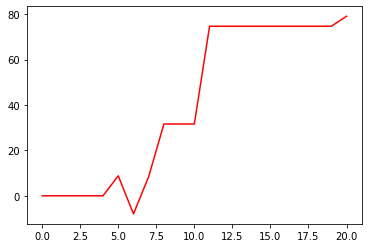

1.4741128807143142
17.267334633441116
0          NaN
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.001172
6    -0.002235
7     0.002195
8     0.003089
9     0.000000
10    0.000000
11    0.005720
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.000000
20    0.000582
Name: Combine, dtype: float64
4.055139719287233


In [5]:
#运行model
import numpy as np
import pandas as pd
import json
import requests
import urllib3
import tushare as ts
from datetime import datetime
from os.path import join
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from scipy import optimize
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import statistics

import yfinance as yf
from arch import arch_model
from arch.__future__ import reindexing
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('data.csv') #data
data['Time'] = pd.to_datetime(data['Time'])

# 匹配到用户输入日期之前一年的数据
one_year_ago = datetime(start_year, month, 1)
one_year_later = datetime(end_year, month, 1)
#training = data[data['Time'] >= one_year_ago]
training = data[(data['Time'] >= one_year_ago) & (data['Time'] <= one_year_later)]
# 匹配到用户输入日期所在月份的数据
start_of_month = datetime(end_year, month, 1)
end_of_month = datetime(end_year, month, last_day)
testing1 = data[(data['Time'] >= start_of_month) & (data['Time'] <= end_of_month)]
testing = data[(data['Time'] >= start_of_month) & (data['Time'] <= end_of_month)]

#model
Matrix = data.drop(training.columns[0:2], axis=1, inplace=False)
Matrix = Matrix.to_numpy()
#intercept = 0，常量alpha
lin = Lasso(alpha=5,fit_intercept=False,precompute=True,max_iter=1000,
            positive=True, random_state=9999, selection='random')
lin.fit(training[training.columns[2:]], training[training.columns[1]])
ratio = lin.coef_ #print(ratio)
vector = list(ratio)
i = 0
#while i < len(vector):
  
    # replace hardik with shardul
    #if vector[i] <0.1:
        #vector[i] = 0 
    #i += 1
print(vector)
Matrix = training.drop(training.columns[0:2], axis=1, inplace=False)
Matrix = Matrix.to_numpy()
z = np.dot(Matrix,vector)
value = training.iloc[:,1].to_numpy()
z = z.flatten()
residuals = np.subtract(z,value)
mod = AutoReg(residuals, lags=1)
result = mod.fit()
print(result.summary())
residuals
adf = adfuller(residuals, maxlag = 1)
AllMatrix = data.drop(data.columns[0:2], axis=1, inplace=False)
AllMatrix = AllMatrix.to_numpy()
z = np.dot(AllMatrix,vector)
value = data.iloc[:,1].to_numpy()
z = z.flatten()
Allresiduals = np.subtract(z,value)
Allresiduals = Allresiduals[25:] #需要确认

rolling_predictions = []
test_size = num_days

for i in range(test_size):
    train = Allresiduals[:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
    
rolling_predictions = pd.Series(rolling_predictions)

alpha = result.params[0]
beta = result.params[1]
sigma2 = result.sigma2
average = alpha/(1-beta)
sd = np.sqrt(sigma2 / (1-beta**2))

Matrix = training.drop(training.columns[0:2], axis=1, inplace=False)
Matrix = Matrix.to_numpy()
train_portfolio = np.dot(Matrix,vector)
train_futures = training.iloc[:,1].to_numpy()
train_futures = train_futures.flatten()
Matrix = testing1.drop(testing1.columns[0:2], axis=1, inplace=False)
Matrix = Matrix.to_numpy()
test_portfolio = np.dot(Matrix,vector)
test_futures = testing1.iloc[:,1].to_numpy()
test_futures = test_futures.flatten()

residuals_test = np.subtract(test_portfolio,test_futures)

#forecast

Matrix = data.drop(data.columns[0:2], axis=1, inplace=False)
Matrix = Matrix.to_numpy()
z = np.dot(Matrix,vector)
value = data.iloc[:,1].to_numpy()
z = z.flatten()
residuals = np.subtract(z,value)
prediction = []

mod = sm.tsa.SARIMAX(residuals[0:len(training.index)+0], order=(1, 0, 0), trend='t')
fore = mod.fit()

def cross(paramt):
    a,b= paramt
    Backtest = pd.DataFrame()
    Backtest['Spread'] = residuals[:len(training.index)]
    Backtest['Portfolio'] = train_portfolio
    Backtest['Futures'] = train_futures
    Backtest['Portfolio Position'] = np.zeros(len(Backtest.index))
    Backtest['Futures Position'] = np.zeros(len(Backtest.index))
    upperbound = a
    lowerbound = b

    for j in range(len(Backtest.index)-1):
        if Backtest.iloc[j,3] == 0 and Backtest.iloc[j,4] == 0:
            if Backtest.iloc[j+1,0] < lowerbound:
                Backtest.iloc[j+1,3] = 1
                Backtest.iloc[j+1,4] = -1
            else:
                Backtest.iloc[j+1,3] = 0
                Backtest.iloc[j+1,4] = 0
        if Backtest.iloc[j,3] == 1 and Backtest.iloc[j,4] == -1:
            if Backtest.iloc[j+1,0] > average and Backtest.iloc[j+1,0] < upperbound:
                Backtest.iloc[j+1,3] = 1
                Backtest.iloc[j+1,4] = 0
            elif Backtest.iloc[j+1,0] < average:
                Backtest.iloc[j+1,3] = 1
                Backtest.iloc[j+1,4] = -1
            elif Backtest.iloc[j+1,0] > upperbound:
                Backtest.iloc[j+1,3] = 0
                Backtest.iloc[j+1,4] = 0
        if Backtest.iloc[j,3] == 1 and Backtest.iloc[j,4] == 0:
            if Backtest.iloc[j+1,0] > average and Backtest.iloc[j+1,0] > upperbound:
                Backtest.iloc[j+1,3] = 0
                Backtest.iloc[j+1,4] = 0
            else:
                Backtest.iloc[j+1,3] = 1
                Backtest.iloc[j+1,4] = 0

    Portfolioentrypoint = []
    Futuresentrypoint = []
    Backtest['Profit for portfolio'] = np.zeros(len(Backtest.index))
    Backtest['Futures Profit'] = np.zeros(len(Backtest.index))
    for j in range(len(Backtest.index)-1):
        if Backtest.iloc[j+1,3] != Backtest.iloc[j,3]:
            if Backtest.iloc[j+1,3]==-1 and Backtest.iloc[j,3]==0:
                entrypoint = Backtest.iloc[j+1,0]
                Backtest.iloc[j+1,5] = Backtest.iloc[j,5]
            elif Backtest.iloc[j+1,3]==1 and Backtest.iloc[j,3]==0:
                entrypoint = Backtest.iloc[j+1,0]
                Backtest.iloc[j+1,5] = Backtest.iloc[j,5]
            elif Backtest.iloc[j+1,3]==0 and Backtest.iloc[j,3]==1:
                Backtest.iloc[j+1,5] = Backtest.iloc[j,5] + entrypoint - Backtest.iloc[j+1,0]
            elif Backtest.iloc[j+1,3]==0 and Backtest.iloc[j,3]==-1:
                Backtest.iloc[j+1,5] = Backtest.iloc[j,5] + Backtest.iloc[j+1,0] - entrypoint
        else:
            Backtest.iloc[j+1,5] = Backtest.iloc[j,5]

    for j in range(len(Backtest.index)-1):
        if Backtest.iloc[j+1,3] != Backtest.iloc[j,3]:
            if Backtest.iloc[j+1,3]==1 and Backtest.iloc[j,3]==0:
                Portfolioentrypoint = Backtest.iloc[j+1,1]
                Backtest.iloc[j+1,5] = Backtest.iloc[j,5]
            elif Backtest.iloc[j+1,3]==0 and Backtest.iloc[j,3]==1:
                Backtest.iloc[j+1,5] = Backtest.iloc[j,5] + Backtest.iloc[j+1,1] - Backtest.iloc[j,1]
        else:
            if Backtest.iloc[j+1,3]==0 and Backtest.iloc[j,3]==0:
                Backtest.iloc[j+1,5] = Backtest.iloc[j,5]
            elif Backtest.iloc[j+1,3]==1 and Backtest.iloc[j,3]==1 and Backtest.iloc[j-1,3]==1:
                Backtest.iloc[j+1,5] = Backtest.iloc[j,5] + Backtest.iloc[j+1,1] - Backtest.iloc[j,1]
            elif Backtest.iloc[j+1,3]==1 and Backtest.iloc[j,3]==1 and Backtest.iloc[j-1,3]==0:
                Backtest.iloc[j+1,5] = Backtest.iloc[j,5] + Backtest.iloc[j+1,1] - Portfolioentrypoint  

    for j in range(len(Backtest.index)-1):
        if Backtest.iloc[j+1,4] != Backtest.iloc[j,4]:
            if Backtest.iloc[j+1,4]==-1 and Backtest.iloc[j,4]==0:
                Futuresentrypoint = Backtest.iloc[j+1,2]
                Backtest.iloc[j+1,6] = Backtest.iloc[j,6]
            elif Backtest.iloc[j+1,4]==0 and Backtest.iloc[j,4]==-1:
                Backtest.iloc[j+1,6] = Backtest.iloc[j,6] + Backtest.iloc[j,2] - Backtest.iloc[j+1,2]
        else:
            if Backtest.iloc[j+1,4]==0 and Backtest.iloc[j,4]==0:
                Backtest.iloc[j+1,6] = Backtest.iloc[j,6]
            elif Backtest.iloc[j+1,4]==-1 and Backtest.iloc[j,4]==-1 and Backtest.iloc[j-1,4]==-1:
                Backtest.iloc[j+1,6] = Backtest.iloc[j,6] + Backtest.iloc[j,2] - Backtest.iloc[j+1,2]
            elif Backtest.iloc[j+1,4]==-1 and Backtest.iloc[j,4]==-1 and Backtest.iloc[j-1,4]==0:
                Backtest.iloc[j+1,6] = Backtest.iloc[j,6] - Backtest.iloc[j+1,2] + Futuresentrypoint
    Backtest['Combine'] = Backtest['Profit for portfolio'] + Backtest['Futures Profit']
    Backtest['Difference'] = Backtest['Combine'].diff()
    Backtest['Difference'] = Backtest['Difference'].fillna(0)
    Backtest['Difference'].replace([np.inf, -np.inf], 0, inplace=True)
    volatility = statistics.stdev(Backtest['Difference'])
    ratio = Backtest.iloc[-1,7] / volatility / np.sqrt(len(Backtest.index))

    return -ratio

y = [average+sd,average-sd]
optimal = optimize.minimize(cross, y, method='COBYLA')

alpha = result.params[0]
beta = result.params[1]
sigma2 = result.sigma2
average = alpha/(1-beta)
sd = np.sqrt(sigma2 / (1-beta**2))

Backtest = pd.DataFrame()
Backtest['Spread'] = residuals_test
Backtest['Portfolio'] = test_portfolio
Backtest['Futures'] = test_futures
Backtest['Volatility'] = rolling_predictions
Backtest['Upper'] = average + 1*rolling_predictions
Backtest['Lower'] = average - 1*rolling_predictions
Backtest['Portfolio Position'] = np.zeros(len(Backtest.index))
Backtest['Futures Position'] = np.zeros(len(Backtest.index))

Portfolioentrypoint = []
Futuresentrypoint = []

if Backtest.iloc[0,0] < Backtest.iloc[0,5]:
    Backtest.iloc[0,6] = 1
    Backtest.iloc[0,7] = -1
    Portfolioentrypoint = Backtest.iloc[0,1]
    Futuresentrypoint = Backtest.iloc[0,2]

for j in range(len(Backtest.index)-1):
    if Backtest.iloc[j,6] == 0 and Backtest.iloc[j,7] == 0:
        if Backtest.iloc[j+1,0] < Backtest.iloc[j+1,5]:
            Backtest.iloc[j+1,6] = 1
            Backtest.iloc[j+1,7] = -1
        else:
            Backtest.iloc[j+1,6] = 0
            Backtest.iloc[j+1,7] = 0
    if Backtest.iloc[j,6] == 1 and Backtest.iloc[j,7] == -1:
        if Backtest.iloc[j+1,0] > average:
            Backtest.iloc[j+1,6] = 0
            Backtest.iloc[j+1,7] = 0
        elif Backtest.iloc[j+1,0] < average:
            Backtest.iloc[j+1,6] = 1
            Backtest.iloc[j+1,7] = -1


Backtest['Profit for portfolio'] = np.zeros(len(Backtest.index))
Backtest['Futures Profit'] = np.zeros(len(Backtest.index))

for j in range(len(Backtest.index)-1):
    if Backtest.iloc[j+1,6] != Backtest.iloc[j,6]:
        if Backtest.iloc[j+1,6]==1 and Backtest.iloc[j,6]==0:
            Portfolioentrypoint = Backtest.iloc[j+1,1]
            Backtest.iloc[j+1,8] = Backtest.iloc[j,8]
        elif Backtest.iloc[j+1,6]==0 and Backtest.iloc[j,6]==1:
            Backtest.iloc[j+1,8] = Backtest.iloc[j,8] + Backtest.iloc[j+1,1] - Backtest.iloc[j,1]
    else:
        if Backtest.iloc[j+1,6]==0 and Backtest.iloc[j,6]==0:
            Backtest.iloc[j+1,8] = Backtest.iloc[j,8]
        elif Backtest.iloc[j+1,6]==1 and Backtest.iloc[j,6]==1 and Backtest.iloc[j-1,6]==1:
            Backtest.iloc[j+1,8] = Backtest.iloc[j,8] + Backtest.iloc[j+1,1] - Backtest.iloc[j,1]
        elif Backtest.iloc[j+1,6]==1 and Backtest.iloc[j,6]==1 and Backtest.iloc[j-1,6]==0:
            Backtest.iloc[j+1,8] = Backtest.iloc[j,8] + Backtest.iloc[j+1,1] - Portfolioentrypoint  

for j in range(len(Backtest.index)-1):
    if Backtest.iloc[j+1,7] != Backtest.iloc[j,7]:
        if Backtest.iloc[j+1,7]==-1 and Backtest.iloc[j,7]==0:
            Futuresentrypoint = Backtest.iloc[j+1,2]
            Backtest.iloc[j+1,9] = Backtest.iloc[j,9]
        elif Backtest.iloc[j+1,7]==0 and Backtest.iloc[j,7]==-1:
            Backtest.iloc[j+1,9] = Backtest.iloc[j,9] + Backtest.iloc[j,2] - Backtest.iloc[j+1,2]
    else:
        if Backtest.iloc[j+1,7]==0 and Backtest.iloc[j,7]==0:
            Backtest.iloc[j+1,9] = Backtest.iloc[j,9]
        elif Backtest.iloc[j+1,7]==-1 and Backtest.iloc[j,7]==-1 and Backtest.iloc[j-1,7]==-1:
            Backtest.iloc[j+1,9] = Backtest.iloc[j,9] + Backtest.iloc[j,2] - Backtest.iloc[j+1,2]
        elif Backtest.iloc[j+1,7]==-1 and Backtest.iloc[j,7]==-1 and Backtest.iloc[j-1,7]==0:
            Backtest.iloc[j+1,9] = Backtest.iloc[j,9] - Backtest.iloc[j+1,2] + Futuresentrypoint
    Backtest['Combine'] = Backtest['Profit for portfolio'] + Backtest['Futures Profit']
    Backtest['Difference'] = Backtest['Combine'].diff()
    Backtest['Difference'] = Backtest['Difference'].fillna(0)
    Backtest['Difference'].replace([np.inf, -np.inf], 0, inplace=True)
    volatility = statistics.stdev(Backtest['Difference'])
    ratio = Backtest.iloc[-1,10] / volatility / np.sqrt(len(Backtest.index))

#print(Backtest['Combine'])
#Backtest['Combine'].to_csv("PnL Comparison3(alpha=0.1).csv")
plt.plot(Backtest['Combine'],color='red')
plt.show()

print(ratio)
print(Backtest.iloc[-1,10] / np.sqrt(len(Backtest.index)))
#Backtest

Initialpoint = Backtest.iloc[0,2]
FuturesProfit = Backtest.iloc[:627,2]-Initialpoint
FuturesReturn = FuturesProfit/Initialpoint
CombineReturn = Backtest.iloc[:627,10]*(8000000/6000)/10000000

Wealth = CombineReturn*10000000 +10000000
Ret = Wealth.pct_change()
Sharpe = (Ret.mean()*252-0.03)/(Ret.std()*np.sqrt(252))
print(Ret)
print(Sharpe)

Backtest.to_csv('Backtest.csv')

name = list(data.columns)
name = name[2:]
weight = pd.DataFrame(vector)
weight.index = name
weight['Price'] = data.iloc[0,2:]
weight['Value'] = weight.iloc[:,0]*weight.iloc[:,1]
weight['Ratio'] = weight.iloc[:,2]
#weight['Ratio'] = (weight['Value'] / weight['Value'].sum()).round(3)
weight['Ratio'] = (weight['Value'] / weight['Value'].sum()).astype(float).round(3)
#print(weight.to_string())
weight.to_csv('WeightTestingPeriod.csv')

backtest_file = pd.read_csv('backtest.csv')
backtest_file.rename(columns={backtest_file.columns[0]: 'Dates'}, inplace=True)
list_testing_time=testing['Time'].tolist()
backtest_file['Dates'] = list_testing_time
backtest_file.to_csv('backtest.csv', index=False)

df_backtest = pd.read_csv('backtest.csv')
matched_row = df_backtest[df_backtest.iloc[:,0] == futures_date_str]

In [6]:
#输出结果
print(matched_row) #所输入日期当天的backtest
print(weight) #所输入日期所在月份的portfolio中stock的weights

        Dates     Spread    Portfolio  Futures  Volatility      Upper  \
7  2023-08-10 -21.422083  3970.377917   3991.8   22.659537  22.321633   

      Lower  Portfolio Position  Futures Position  Profit for portfolio  \
7 -22.99744                 1.0              -1.0            -15.151666   

   Futures Profit   Combine  Difference  
7            23.6  8.448334   16.442995  
                  0       Price       Value  Ratio
688981.SH  0.899999       40.18   36.161974  0.009
688599.SH  0.000000   80.927255         0.0  0.000
688561.SH  2.265251        50.6  114.621708  0.027
688396.SH  0.631873   50.967146    32.20477  0.008
688363.SH  0.000000  155.122759         0.0  0.000
...             ...         ...         ...    ...
000069.SZ  0.000000        5.56         0.0  0.000
000066.SZ  0.000000    9.702062         0.0  0.000
000063.SZ  0.180755   23.693717    4.282753  0.001
000002.SZ  0.000000   15.109124         0.0  0.000
000001.SZ  0.000000   12.124486         0.0  0.000

[373 

In [7]:
matched_row

,Dates,Spread,Portfolio,Futures,Volatility,Upper,Lower,Portfolio Position,Futures Position,Profit for portfolio,Futures Profit,Combine,Difference
7,2023-08-10,-21.422083,3970.377917,3991.8,22.659537,22.321633,-22.99744,1.0,-1.0,-15.151666,23.6,8.448334,16.442995


In [9]:
weight.to_csv('weight.csv')